References
- [Chris Mccormick finetuning BERT for SQUAD](https://colab.research.google.com/drive/16VjEulbATgok4mELTSaq7GTQdh3JGhGy#scrollTo=Xm1wTn09RAR7)
- [Discussion Regarding finetuning T5](https://github.com/huggingface/transformers/issues/4426) | [Exploring T5 by patil suraj](https://github.com/patil-suraj/exploring-T5)
    - [SQUAD QA finetuning for T5](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/T5_on_TPU.ipynb#scrollTo=KdmKlMkfcLa0)
    - [T5 finetuning for non extractive tasks](https://colab.research.google.com/drive/176NSaYjc2eeI-78oLH_F9-YV3po3qQQO?usp=sharing)
- [Google's T5 fine tuning example for QA](https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/master/notebooks/t5-trivia.ipynb#scrollTo=6rU32DjyeLuL)

## Import from Baseline Code

In [1]:
# https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes, as dict.key_name, not as dict["key_name"] """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [2]:
import logging
import os
import sys

from typing import List, Callable, NoReturn, NewType, Any
import dataclasses
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer

from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

from tokenizers import Tokenizer
from tokenizers.models import WordPiece

from baseline.utils_qa import postprocess_qa_predictions, check_no_error
from baseline.trainer_qa import QuestionAnsweringTrainer
from baseline.retrieval import SparseRetrieval

import yaml

# Read config.yaml file
with open("config.yaml") as infile:
    SAVED_CFG = yaml.load(infile, Loader=yaml.FullLoader)
    SAVED_CFG = dotdict(SAVED_CFG)

# arguments setting
data_args = dotdict(SAVED_CFG.data)
model_args = dotdict(SAVED_CFG.custom_model)
training_args = TrainingArguments(
    output_dir="./results",  # output directory
    save_total_limit=5,  # number of total save model.
    save_steps=model_args.save_steps,  # model saving step.
    num_train_epochs=model_args.num_train_epochs,  # total number of training epochs
    learning_rate=model_args.learning_rate,  # learning_rate
    per_device_train_batch_size=model_args.batch_size,  # batch size per device during training
    per_device_eval_batch_size=model_args.batch_size,  # batch size for evaluation
    warmup_steps=model_args.warmup_steps,  # number of warmup steps for learning rate scheduler
    weight_decay=model_args.weight_decay,  # strength of weight decay
    logging_dir="./logs",  # directory for storing logs
    logging_steps=100,  # log saving step.
    evaluation_strategy="steps",  # evaluation strategy to adopt during training
    # `no`: No evaluation during training.
    # `steps`: Evaluate every `eval_steps`.
    # `epoch`: Evaluate every end of epoch.
    eval_steps=500,  # evaluation step.
    load_best_model_at_end=True,
)


In [3]:
import torch
import torch.nn.functional as F
from transformers import BertModel, BertPreTrainedModel, AdamW,AutoTokenizer, TrainingArguments, get_linear_schedule_with_warmup
from datasets import load_metric, load_from_disk, Dataset, DatasetDict
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
from tqdm import tqdm
import random

tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path)
datasets = load_from_disk(data_args.dataset_name)
train_dataset_from_huggingface = datasets['train']
valid_dataset_from_huggingface = datasets['validation']

In [4]:
#train dataset, train dataloader
q_seqs = tokenizer(
    train_dataset_from_huggingface['question'], 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt',
    return_token_type_ids=False,  # for RoBERTa
    )
p_seqs = tokenizer(
    train_dataset_from_huggingface['context'], 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt',
    return_token_type_ids=False,  # for RoBERTa
    )
# print(q_seqs[0])
train_dataset = TensorDataset(
    p_seqs['input_ids'], 
    p_seqs['attention_mask'], 
    # p_seqs['token_type_ids'],
    q_seqs['input_ids'], 
    q_seqs['attention_mask'], 
    # q_seqs['token_type_ids']
    )
train_loader = DataLoader(train_dataset,batch_size=model_args.batch_size)

#valid dataset, valid dataloader
q_seqs = tokenizer(
    valid_dataset_from_huggingface['question'], 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt',
    return_token_type_ids=False,  # for RoBERTa
    )
p_seqs = tokenizer(
    valid_dataset_from_huggingface['context'], 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt',
    return_token_type_ids=False,  # for RoBERTa
    )
# print(q_seqs[0])
valid_dataset = TensorDataset(
    p_seqs['input_ids'], 
    p_seqs['attention_mask'], 
    # p_seqs['token_type_ids'],
    q_seqs['input_ids'], 
    q_seqs['attention_mask'], 
    # q_seqs['token_type_ids']
    )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=model_args.batch_size
    )


## Import from Fine_Tune_BERT_on_SQuAD_v1_1.ipynb

In [5]:
# look inside dataset at huggingface
vars(train_dataset_from_huggingface)

#  title: string
#  context: string
#  question: string
#  id: string
#  answers: struct < answer_start: list<item: int64>, text: list<item: string> >
#    child 0, answer_start: list<item: int64>
#        child 0, item: int64
#    child 1, text: list<item: string>
#        child 0, item: string
#  document_id: int64

{'_info': DatasetInfo(description='', citation='', homepage='', license='', features={'__index_level_0__': Value(dtype='int64', id=None), 'answers': {'answer_start': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}, 'context': Value(dtype='string', id=None), 'document_id': Value(dtype='int64', id=None), 'id': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, builder_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None),
 '_split': None,
 '_indexes': {},
 '_data': pyarrow.Table
 title: string
 context: string
 question: string
 id: string
 answers: struct<answer_start: list<item: int64>, text: list<item: string>>
   child 0, answer_start: list<item: int64>
       child 0

In [6]:
train_dataset_from_huggingface[1]

{'title': '인사조직관리',
 'context': "'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 6.25전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 아메리카 대륙에서 신생국가가 형성되는 시기였고, 미국은 전쟁 이후 경제적 변화에 기업이 적응을 해야 하던 시기였다. 특히 1954년 피터 드러커의 저서 《경영의 실제》는 현대적 경영의 기준을 제시하여서, 기존 근대적 인사조직관리를 넘어선 현대적 인사조직관리의 전환점이 된다. 드러커는 경영자의 역할을 강조하며 경영이 현시대 최고의 예술이자 과학이라고 주장하였고 , 이 주장은 21세기 인사조직관리의 역할을 자리매김했다.\\n\\n현대적 인사조직관리와 근대 인사조직관리의 가장 큰 차이는 통합이다. 19세기의 영향을 받던 근대적 경영학(고전적 경영)의 흐름은 기능을 강조하였지만, 1950년대 이후의 현대 경영학은 통합을 강조하였다. 기능이 분화된 '기계적인 기업조직' 이해에서 다양한 기능을 인사조직관리의 목적, 경영의 목적을 위해서 다양한 분야를 통합하여 '유기적 기업 조직' 이해로 전환되었다. 이 통합적 접근방식은 과정, 시스템, 상황을 중심으로 하는 인사조직관리 방식을 형성했다.",
 'question': '현대적 인사조직관리의 시발점이 된 책은?',
 'id': 'mrc-0-004397',
 'answers': {'answer_start': [212], 'text': ['《경영의 실제》']},
 'document_id': 51638,
 '__index_level_0__': 2873}

In [7]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path)
config = AutoConfig.from_pretrained(model_args.model_name_or_path)

In [8]:
tokens = tokenizer.tokenize(train_dataset_from_huggingface[1]['question'])
" ".join(tokens)

'현대 ##적 인사 ##조 ##직 ##관리 ##의 시발점 ##이 된 책 ##은 ?'

## Simple EDA

In [9]:
import logging

# By default, the tokenizer will spit out a warning whenever we tokenize a 
# sample which ends up being more than 512 tokens. We don't care about that for
# now, though, and this cell will produce a lot of those warnings! So we'll 
# adjust the logging settings to suppress those warnings and keep the output
# cell cleaner.
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing {:,} examples...'.format(len(train_dataset_from_huggingface)))

# For each example...
for (i, ex) in enumerate(train_dataset_from_huggingface):

    # Report progress.
    if ((i % 3000) == 0):
        print('  Tokenized {:,}.'.format(i))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(ex['question'], 
                                 ex['context'],
                                 add_special_tokens = True,
                                 truncation=False
                                 )

    # Record the non-truncated length.
    lengths.append(len(input_ids))

print('DONE.')

Tokenizing 3,952 examples...
  Tokenized 0.
  Tokenized 3,000.
DONE.


In [10]:
import numpy as np

print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 256 tokens
   Max length: 1,190 tokens
Median length: 462.0 tokens


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


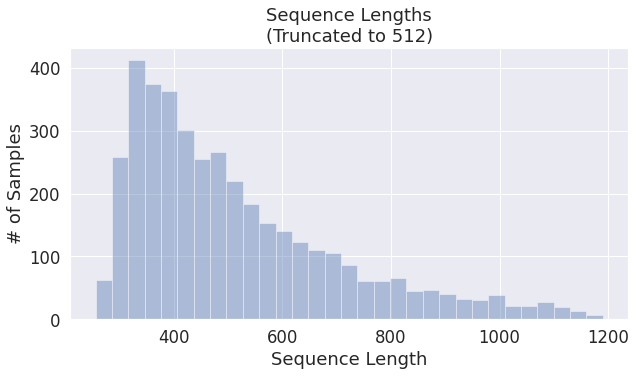

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any sequence lengths greater than 512.
# trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of truncated lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Sequence Lengths\n(Truncated to 512)')
plt.xlabel('Sequence Length')
plt.ylabel('# of Samples')

plt.show()

In [12]:
import numpy as np

# Cast the list to a numpy array so we can use some numpy features.
lengths = np.asarray(lengths)

# Get the total number of comments.
num_comments = len(lengths)

# Check the following lengths:
max_lens = [128, 256, 300, 384, 512]

print('How many comments will be truncated?\n')

# For each choice...
for max_len in max_lens:

    # Calculate how many comments will be truncacted.
    num_over = np.sum(lengths > max_len)

    # And as a percentage.
    prcnt_over = float(num_over) / float(num_comments)

    print('max_len = {:}  -->  {:>7,} of {:>7,}  ({:>5.1%})  ' \
          'will be truncated '.format(
              max_len, num_over, num_comments, prcnt_over
          ))

How many comments will be truncated?

max_len = 128  -->    3,952 of   3,952  (100.0%)  will be truncated 
max_len = 256  -->    3,951 of   3,952  (100.0%)  will be truncated 
max_len = 300  -->    3,788 of   3,952  (95.9%)  will be truncated 
max_len = 384  -->    2,742 of   3,952  (69.4%)  will be truncated 
max_len = 512  -->    1,545 of   3,952  (39.1%)  will be truncated 


In [13]:
import time
import torch
from tqdm import tqdm

time_elapsed = time.time()

list_input_ids = []
list_attention_masks = []
# list_token_type_ids = []
list_start_positions = []
list_end_positions = []

num_dropped = 0

for (item_num, item) in tqdm(enumerate(train_dataset_from_huggingface)):
    # print(item)
    # Report progress.
    if ((item_num % 1000) == 0) and (not item_num == 0):
        print('    Processed {:,} examples in {:.0f} seconds.'.format(
            item_num, time.time() - time_elapsed
        ))
    # print(item['answers']['text'][0])
    answer_tokens = tokenizer.tokenize(item['answers']['text'][0])
    # print(answer_tokens)
    len_answer_tokens = len(answer_tokens)

    str_masked = ' '.join([tokenizer.mask_token]*len_answer_tokens)

    start_char_i = item['answers']['answer_start'][0]
    end_char_i = start_char_i + len(item['answers']['text'])

    masked_context = \
        item['context'][:start_char_i] + \
        str_masked + \
        item['context'][end_char_i:]

    # Tokenize the context and the answer.
    encoded_dict = tokenizer.encode_plus(
        item['question'],
        masked_context,
        add_special_tokens = True,
        max_length=512,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_tensors='pt'
    )
    input_ids = encoded_dict['input_ids']
    
    is_mask_token = (input_ids[0] == tokenizer.mask_token_id)
    mask_token_indices = is_mask_token.nonzero(as_tuple=False)[:, 0]

    if not len(mask_token_indices) == len_answer_tokens:
        num_dropped += 1
        continue

    start_index = mask_token_indices[0]
    end_index = mask_token_indices[-1]

    answer_token_ids = tokenizer.encode(
        answer_tokens[0],
        add_special_tokens=False,
        return_tensors='pt'
    )

    input_ids[0, start_index:end_index+1] = answer_token_ids

    list_input_ids.append(input_ids)
    list_attention_masks.append(encoded_dict['attention_mask'])

    list_start_positions.append(start_index)
    list_end_positions.append(end_index)

list_input_ids = torch.cat(list_input_ids, dim=0)
list_attention_masks = torch.cat(list_attention_masks, dim=0)
list_start_positions = torch.tensor(list_start_positions)
list_end_positions = torch.tensor(list_end_positions)

print('Dropped {:,} examples.'.format(num_dropped))

0it [00:00, ?it/s]/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1064it [00:02, 393.31it/s]

    Processed 1,000 examples in 3 seconds.


2069it [00:05, 423.28it/s]

    Processed 2,000 examples in 5 seconds.


3052it [00:07, 402.24it/s]

    Processed 3,000 examples in 7 seconds.


3952it [00:09, 408.37it/s]

Dropped 246 examples.


In [14]:
print('Tokenized {:,} examples.'.format(len(list_input_ids)))

print('\nDropped {:,} examples.'.format(num_dropped))

Tokenized 3,706 examples.

Dropped 246 examples.


In [19]:
from transformers import AutoModelForQuestionAnswering, AutoConfig
from adamp import AdamP

model_config = AutoConfig.from_pretrained(model_args.model_name_or_path)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_args.model_name_or_path,
    config=model_config,
    )
model

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              

In [20]:
model_config.DEBUG = True
device = torch.device('cuda:0' if torch.cuda.is_available() and model_config.DEBUG == False else 'cpu')

3706

In [22]:
import numpy as np
from torch.utils.data import TensorDataset

dataset = TensorDataset(list_input_ids, 
                            list_attention_masks, 
                            list_start_positions, 
                            list_end_positions)

print('Dataset size: {:} samples'.format(len(dataset)))

Dataset size: 3706 samples


In [23]:
from torch.utils.data import random_split

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,335 training samples
  371 validation samples


In [24]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Oct 19 08:23:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler, SequentialSampler

import numpy.random
import numpy as np

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Randomly select 10,000 indeces from the training set to use. 
#indeces = np.random.permutation(len(train_dataset))[:10000]

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            #sampler = SubsetRandomSampler(indeces, train_dataset),
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('{:,} training batches & {:,} validation batches'.format(len(train_dataloader), len(validation_dataloader)))

209 training batches & 24 validation batches


In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamP(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
import wandb
import random
import numpy as np



# Flexible integration for any Python script
import wandb


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

wandb.init(project='KLUE-QA', entity='happyface-boostcamp')

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    print('Training {:,} batches...'.format(len(train_dataloader)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


    # The total number of batches per epoch.
    num_batches = len(train_dataloader)

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):


        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_seg_ids = batch[2].to(device)
        b_start_pos = batch[2].to(device)
        b_end_pos = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.QuestionAnsweringModelOutput
        # For our useage here, it returns the loss (because we provided labels)
        # and the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        # token_type_ids = b_seg_ids,
                        start_positions=b_start_pos,
                        end_positions=b_end_pos,
                        return_dict=True)

        # You can see the outputs in the source code here:
        # https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_bert.py#L1601
        # 
        # The forward pass returns the loss, start_logits, and end_logits.
        loss = outputs.loss
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    t0_val = time.time()

    # Tracking results. 
    pred_start, pred_end, true_start, true_end = [], [], [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_seg_ids = batch[2].to(device)
        b_start_pos = batch[2].to(device)
        b_end_pos = batch[3].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                            # token_type_ids=b_seg_ids, 
                            attention_mask=b_input_mask,
                            start_positions=b_start_pos,
                            end_positions=b_end_pos,
                            return_dict=True)

        # The forward pass returns the loss, start_logits, and end_logits.
        loss = outputs.loss
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits        

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        start_logits = start_logits.detach().cpu().numpy()
        end_logits = end_logits.detach().cpu().numpy()
        
        # Move the correct start and end positions back to the CPU.
        b_start_pos = b_start_pos.to('cpu').numpy()
        b_end_pos = b_end_pos.to('cpu').numpy()

        # Find the tokens with the highest `start` and `end` scores.
        answer_start = np.argmax(start_logits, axis=1)
        answer_end = np.argmax(end_logits, axis=1)

        # Store predictions and true labels
        pred_start.append(answer_start)
        pred_end.append(answer_end)
        true_start.append(b_start_pos)
        true_end.append(b_end_pos)

    # Combine the results across the batches.
    pred_start = np.concatenate(pred_start, axis=0)
    pred_end = np.concatenate(pred_end, axis=0)
    true_start = np.concatenate(true_start, axis=0)
    true_end = np.concatenate(true_end, axis=0)
        
    # Count up the number of start index predictions and end index predictions 
    # which match the correct indeces.
    num_start_correct = np.sum(pred_start == true_start)
    num_end_correct = np.sum(pred_end == true_end)

    total_correct = num_start_correct + num_end_correct
    total_indeces = len(true_start) + len(true_end)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = float(total_correct) / float(total_indeces)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # validation_time = format_time(time.time() - t0_val)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    wandb.log(
                    {
                        'train/loss':avg_train_loss, 
                        'train/learning_rate':optimizer.param_groups[0]['lr'], 
                        'eval/loss':avg_val_loss,
                        'eval/accuracy':avg_val_accuracy,
                        }
                        )
    

print("")
print("Training complete!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /opt/ml/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



======== Epoch 1 / 3 ========
Training 209 batches...
